# Sheet 2 - Simulation exercise (Gaussian mixture model - Gibbs sampling) 

In [1]:
using Distributions, StatsPlots, Plots, StatsBase
pyplot()

Plots.PyPlotBackend()

## Sample synthetic dataset from mixture model.

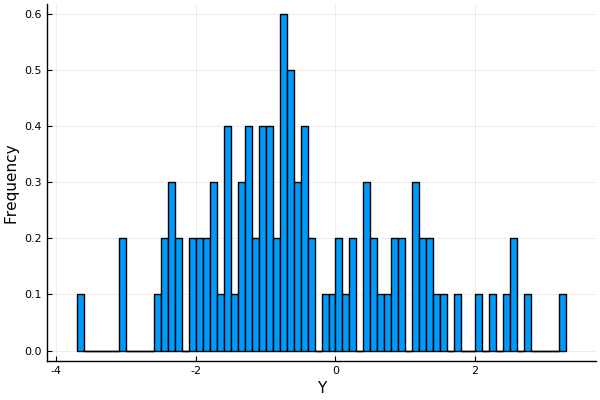

In [492]:
mu    = [-1,1]
sigma2= [1,1]
p     = [0.7,0.3]
w = Weights(p)
M = 100
X = zeros(M)
s = sample(1:2, w,M)
for i = 1:M
    j = s[i]
    X[i]+= rand(Normal(mu[j],sigma2[j]))
end

p = histogram(X,xlabel="Y",ylabel="Frequency",normalize=true,legend=false,nbins=M)
# savefig(p,"./images/Ex6.png")

### Initial step:
* Sample from prior p      ~ Dirichlet
* Sample from prior μk     ~ N(m, tau^2)
* Sample from prior sig2_k ~ IG(alpha, beta)

### After that, sample from the full conditionals:
* Sample Z | p, mu, sig2 , Y ~ P(Z_i = k | p,y,mu,sig2) = p_k*pdf(Normal(mu,sig),y)
* Sample p1,...,pk | Z, mu, sig2, Y ~ Dirichlet (gamma1 + n1,...,gammak + nk)
* Sample sig2_1,...,sig2_k | Z, mu, p, Y $\sim
\text{Inverse Gamma}\left(
\alpha + \frac{n_k}{2}, \beta +
\frac{\sum_{i=1}^{n_k}(x_i - \mu_k)^2}{2}
\right)
$
* Sample mu_1, ... , mu_k | Z, sig2, p, Y$ \sim
N\left(
\frac{n_k \sigma_k ^{-2}\bar{x_k} + \tau^{-2}m}
{n_k\sigma^2_k}
, [n_k\sigma_k^{-2} + \tau^{-2}]^{-1}
\right)$

In [493]:

function SamplePosterior_Z(p,M,mu,sig,y)
    z = zeros(M)
    for n =1:M
        w = zeros(k)
        for i=1:k
            w[i] = p[i]*pdf(Normal(mu[i],sqrt(sig[i])),y[n])
        end
        z[n] = sample(1:k, Weights(w))
    end
#     print(countmap(z))
    return z
end


function SamplePosterior_p(z, gamma)
    n = countmap(z)
    gamma_p = zeros(k)
    for i = 1:k
        try
            gamma_p[i] = gamma[i] + n[i]
        catch
            gamma_p[i] = gamma[i]
        end
    end
    p = rand(Dirichlet(gamma_p))
    return p
end

function SamplePosterior_sigma(z,mu,alpha,beta,y)
    sig = zeros(k)
    n = countmap(z)
    for i = 1:k
        alpha_p = alpha
        try
            alpha_p = alpha + n[i]/2
        catch
            alpha_p = alpha
        end
        beta_p  = beta + sum((y[z .== i].-mu[i]).^2)/2
        sig[i] = rand(InverseGamma(alpha_p,beta_p^(-1)))
    end
    return sig
end

function SamplePosterior_mu(z,m,tau,sig)
    mu = zeros(k)
    n = countmap(z)
    for i = 1:k
        m_p = m
        tau_p = tau
        try
            m_p = ( (sig[i]^(-1))*(sum(y[z .== i])) + (tau^(-1))*m ) / ( n[i]*(sig[i]^(-1) + (tau^(-1))) )
            tau_p = 1/((n[i]*sig[i]^(-1))+tau^(-2))
        catch
            m_p = m
            tau_p = tau
        end
#         println(m_p,"\t", tau_p)
        mu[i]   = rand(Normal(m_p,tau_p))
    end
    return mu
end


function Gibbs_Sampler_Mixture(steps,y,k,gamma,m,tau,alpha,beta)
    #Initilialize by sampling from the priors
    p   = rand(Dirichlet(gamma))
    mu  = rand(Normal(m,tau),k)
    sig = rand(InverseGamma(alpha,beta^(-1)),k)
    
    # Start the updating
    posterior = zeros(steps,k*3)
    for i = 1:steps
        z = SamplePosterior_Z(p,M,mu,sig,y)
        p = SamplePosterior_p(z,gamma)
        mu  = SamplePosterior_mu(z,m,tau,sig)
        sig = SamplePosterior_sigma(z,mu,alpha,beta,y)
        posterior[i,:] = posterior[i,:] + vcat(p,mu,sig)
#         println(posterior[i,:])
    end
    return posterior
end

steps = 1000
y     = X
k = 2
# gamma, m, tau, alpha, beta = [1,1,1],0,1,3,3
gamma, m, tau, alpha, beta = [1,1],0,1,2,2
simulation = Gibbs_Sampler_Mixture(steps,y,k,gamma,m,tau,alpha,beta);


In [494]:
simulation

1000×6 Array{Float64,2}:
 0.122875   0.877125     1.24354   -0.602162  0.0349047    0.000304921
 0.804018   0.195982    -0.438614  -0.647915  0.000287895  0.0298277  
 0.0401665  0.959833    -0.443653  -0.47197   0.124223     0.000225355
 0.970148   0.0298517   -0.432741  -0.473524  0.000242164  0.142443   
 0.0193079  0.980692    -0.420719  -0.427353  0.1981       0.000155589
 0.949463   0.0505371   -0.403324  -0.420759  0.000250786  0.244467   
 0.0306393  0.969361    -0.420585  -0.388909  0.24052      0.000192653
 0.938806   0.0611942   -0.388775  -0.420563  0.00017404   0.108683   
 0.0471425  0.952858    -0.42081   -0.437189  0.074642     0.000171602
 0.97252    0.0274798   -0.451649  -0.409063  0.000175717  0.147562   
 0.0603805  0.939619    -0.457449  -0.423575  0.0902782    0.000220728
 0.990457   0.00954293  -0.44592   -0.420652  0.000204104  0.219078   
 0.0729153  0.927085    -0.457389  -0.396487  0.0591259    0.000185682
 ⋮                                                  

In [491]:
simulation
pdf(Normal(simulation[10,3],sqrt(simulation[10,5])),y[1])
# plot(simulation[:,3])
# plot!(simulation[:,4])
# histogram(y,nbins=100)


3.929491796962375e-8

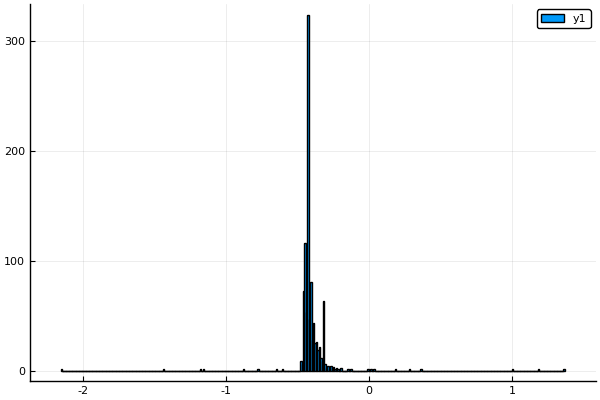

In [495]:
histogram(simulation[:,4])
# histogram!(simulation[:,5])
# histogram!(simulation[:,6])
# matr= zeros(1,9)
# matr[1,:] + vcat(rand(3),rand(3),rand(3))

In [205]:
k = 3
gamma, m, tau, alpha, beta = [1,1,1],0,1,3,1
# function Priors(gamma,m,tau,alpha,beta)
#     rand(Dirichlet())
# end

function Posterior_p(Z,mu,sig2,Y)
    
end

Posterior_p (generic function with 1 method)

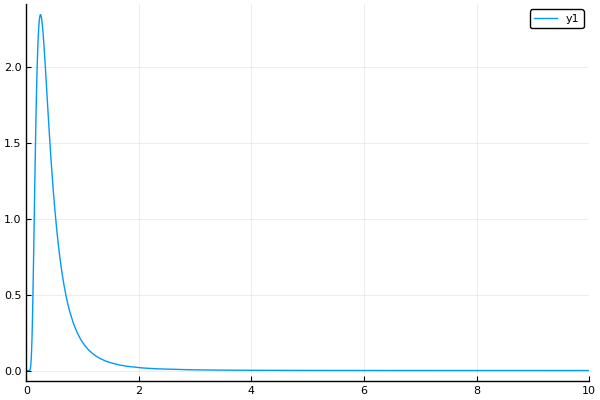

In [129]:
plot(InverseGamma(alpha,beta^-1),xlims=(0,10))